<a href="https://colab.research.google.com/github/nidhisingh2309/BTP-Sem-7/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-unet-collection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
from tensorflow.keras.optimizers import Adam
from keras_unet_collection import models, losses

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
seed = 42
np.random.seed = seed

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [ ]:
import cv2
import numpy as np
import os
import zipfile

# Step 1: Mount Google Drive

# Step 2: Extract the zip file (if not already extracted)
zip_file_path = '/content/drive/MyDrive/Grain_img.zip'  # Path to the zip file in Drive
extract_to_folder = '/content/extracted_images_2'  # Folder where the images will be extracted

# Check if the images are already extracted
if not os.path.exists(extract_to_folder):
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)  # Extract the images to the specified folder
    print("Extraction completed.")
else:
    print(f"Folder {extract_to_folder} already exists. Skipping extraction.")

Extracting zip file...
Extraction completed.


In [ ]:
# Load and preprocess data
image_folder = '/content/extracted_images_2/Grain_img/RG'
mask_folder = '/content/extracted_images_2/Grain_img/RGMask'
#X, y = load_data(image_folder, mask_folder)

# Split data into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#USE THIS BLOCK TO CREATE LISTS IMAGES AND MASKS
# THIS BLOCK DOES NOT ALLOW THE USER TO SELECT WHAT FILES GET USED
# THIS BLOCK IS JUST ALL THE VORO DATASET
#Skip this block if you already made lists in previous block

import os

# Set the directories containing the images and masks
image_dir = '/content/extracted_images_2/Grain_img/RG'
mask_dir = '/content/extracted_images_2/Grain_img/RGMask'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []
# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)


for file in sorted(os.listdir(mask_dir)):

    # Load the corresponding mask and resize to the target size
    mask_file = file.replace('.jpg', '.png')
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)

In [ ]:
# create the X and Y (input and output)

IMG_array = np.array(images)
MASK_array = np.array(masks)

# change the Y to a boolean
MASK_array = np.where(MASK_array < 245, True, False)

mask_length = len(masks)
#basically reduce the 3 channel dimension RGB to just one boolean value

MASK_array = np.any(MASK_array, axis=-1)
MASK_array = MASK_array.reshape(mask_length, IMG_WIDTH, IMG_HEIGHT, 1)

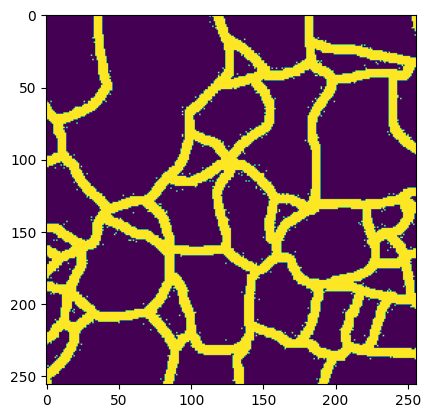

In [ ]:
plt.imshow(MASK_array[50])

In [ ]:
X_train = IMG_array
Y_train = MASK_array

In [ ]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_grains.keras', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

####################################

In [ ]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 316ms/step - accuracy: 0.6143 - loss: 0.6067 - val_accuracy: 0.7701 - val_loss: 0.4094
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7800 - loss: 0.4067 - val_accuracy: 0.8161 - val_loss: 0.3818
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8185 - loss: 0.3707 - val_accuracy: 0.8297 - val_loss: 0.3496
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.8312 - loss: 0.3492 - val_accuracy: 0.8464 - val_loss: 0.3217
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.8484 - loss: 0.3212 - val_accuracy: 0.8514 - val_loss: 0.3113
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.8519 - loss: 0.3137 - val_accuracy: 0.8562 - val_loss: 0.3010
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.8545 - loss: 0.3068 - val_accuracy: 0.8559 - val_loss: 0.3031
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.8559 - loss: 0.3050 - val_accuracy: 0

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 289ms/step - accuracy: 0.6880 - loss: 0.5556 - val_accuracy: 0.7892 - val_loss: 0.3940
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8014 - loss: 0.3910 - val_accuracy: 0.8169 - val_loss: 0.3780
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8177 - loss: 0.3722 - val_accuracy: 0.8347 - val_loss: 0.3452
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.8320 - loss: 0.3466 - val_accuracy: 0.8445 - val_loss: 0.3251
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.8438 - loss: 0.3268 - val_accuracy: 0.8528 - val_loss: 0.3072
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.8504 - loss: 0.3141 - val_accuracy: 0.8538 - val_loss: 0.3047
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.8538 - loss: 0.3062 - val_accuracy: 0.8571 - val_loss: 0.2959
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8558 - loss: 0.3043 - val_accuracy: 0

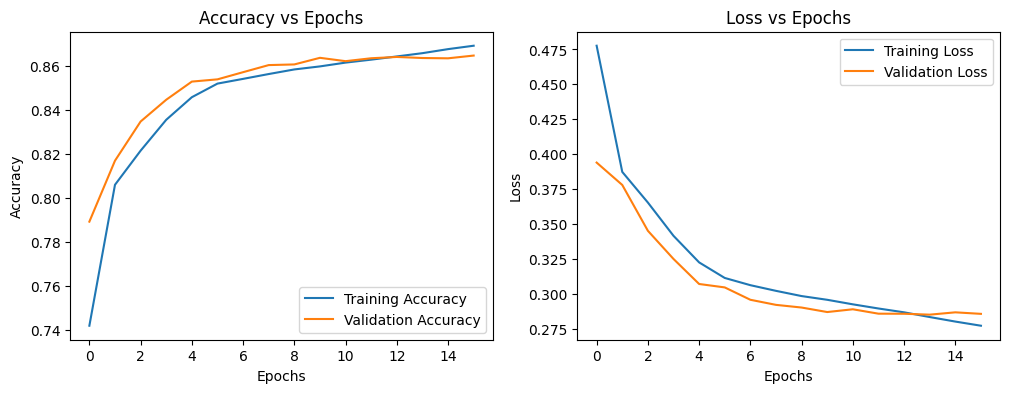

In [ ]:
import matplotlib.pyplot as plt

# Train the model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

# Plot accuracy vs epochs and loss vs epochs
# Accuracy plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.8697 - dice_coefficient: 0.6191 - loss: 0.2764 - val_accuracy: 0.8627 - val_dice_coefficient: 0.5994 - val_loss: 0.2869
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.8760 - dice_coefficient: 0.6378 - loss: 0.2655 - val_accuracy: 0.8604 - val_dice_coefficient: 0.6054 - val_loss: 0.2910


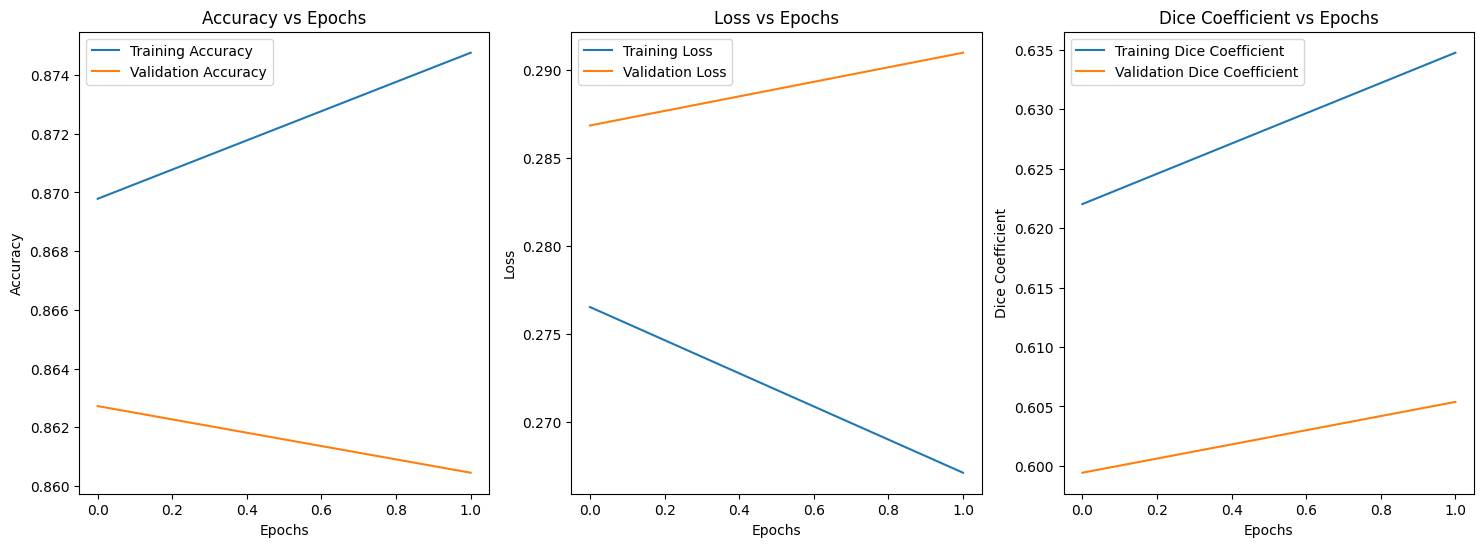

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_true), 'float32')
    y_pred_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_pred), 'float32')
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


# Compile the model with Dice coefficient as a metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient])

# Train the model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

# Plot accuracy, loss, and Dice coefficient vs epochs
plt.figure(figsize=(18, 6))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Dice coefficient plot
plt.subplot(1, 3, 3)
plt.plot(results.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(results.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.show()


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.8774 - dice_coefficient: 0.6435 - loss: 0.2619 - val_accuracy: 0.8625 - val_dice_coefficient: 0.5942 - val_loss: 0.2896
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.8801 - dice_coefficient: 0.6465 - loss: 0.2580 - val_accuracy: 0.8610 - val_dice_coefficient: 0.6001 - val_loss: 0.2933


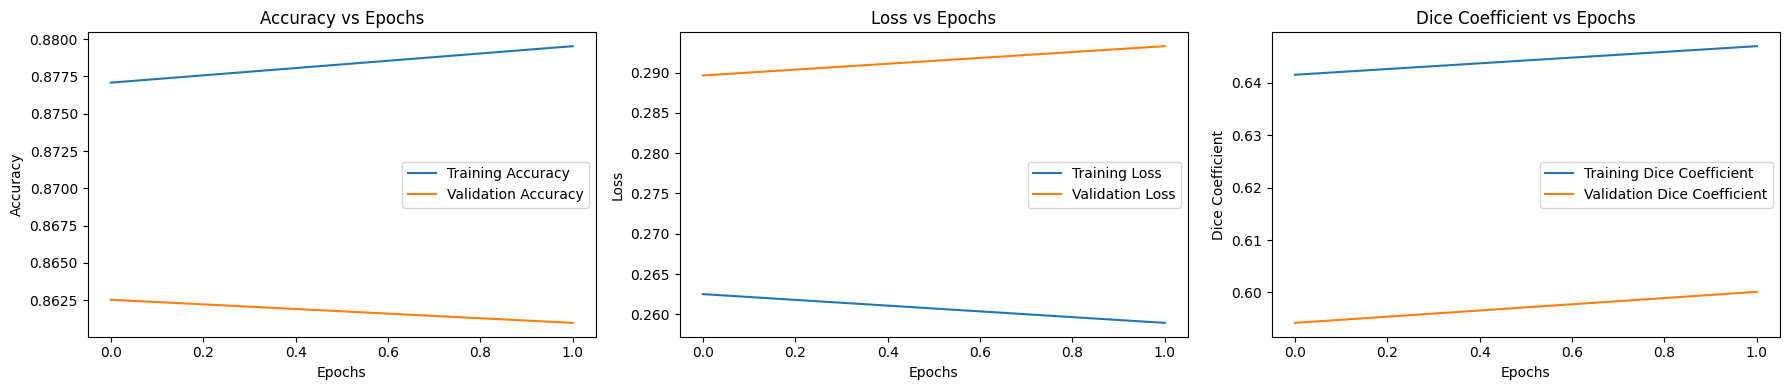

In [ ]:
import matplotlib.pyplot as plt

# Train the model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

# Plot Accuracy, Loss, and Dice Coefficient vs Epochs
plt.figure(figsize=(18, 4))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Dice Coefficient plot
plt.subplot(1, 3, 3)
plt.plot(results.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(results.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step


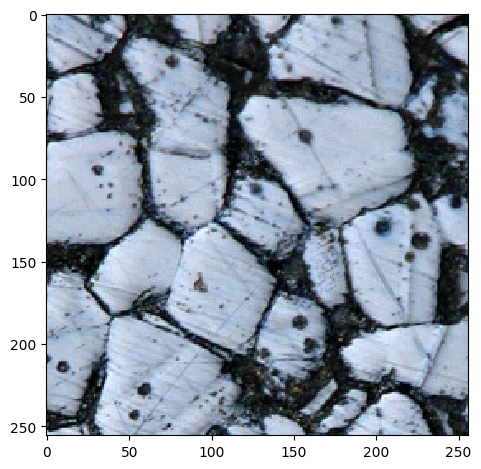

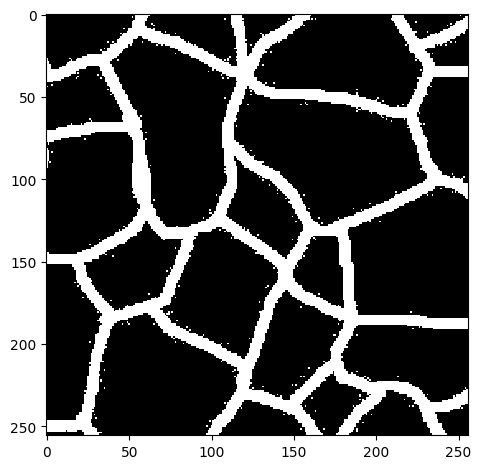

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


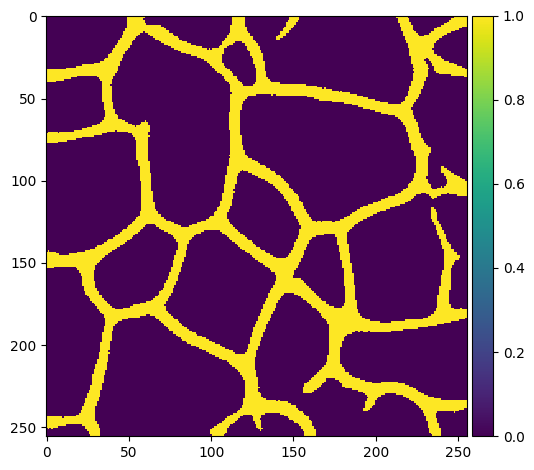

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
Y_train.shape

(480, 256, 256, 1)

In [ ]:
dice_coefficients = []
len(dice_coefficients)

0

In [ ]:
##### DICE SCORE

# Initialize a list to store the dice coefficients for each mask
dice_coefficients = []

loop = len(Y_train)

real_mask = Y_train
pred_mask = preds_train_t


# Iterate through the masks in both directories
for i in range(loop):
  # Calculate the intersection of the masks
  intersection = np.sum(pred_mask[i] * real_mask[i])

  # Calculate the size of each mask
  predicted_mask_size = np.sum(pred_mask[i])
  real_mask_size = np.sum(real_mask[i])

  # Calculate the dice coefficient for the two masks
  dice = 2 * intersection / (predicted_mask_size + real_mask_size)

  # Add the dice coefficient to the list
  dice_coefficients.append(dice)

# Calculate the average dice coefficient for the set of masks
average_dice_coefficient = np.mean(dice_coefficients)

print(f'Average dice coefficient for the data it was trained on: {average_dice_coefficient:.4f}')

Average dice coefficient for the data it was trained on: 0.7257


In [ ]:
#test images

import os

# Set the directories containing the images and masks
image_test_dir = '/content/extracted_images_2/Grain_img/RG'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images_test = []

# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_test_dir)):
    # Load the image and resize to the target size
    img_t = cv2.imread(os.path.join(image_test_dir, file))
    img_t = cv2.resize(img_t, target_size)

    # Append the resized image to the list of images
    images_test.append(img_t)

In [ ]:
import os


seg_test_dir = '/content/extracted_images_2/Grain_img/RGMask'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks

seg_test = []


for file in sorted(os.listdir(seg_test_dir)):

    # Load the corresponding mask and resize to the target size
    #mask_file = file.replace('.jpg', '.png')
    seg_t = cv2.imread(os.path.join(seg_test_dir, file))
    seg_t = cv2.resize(seg_t, target_size)

    # Append the resized mask to the list of masks
    seg_test.append(seg_t)

34


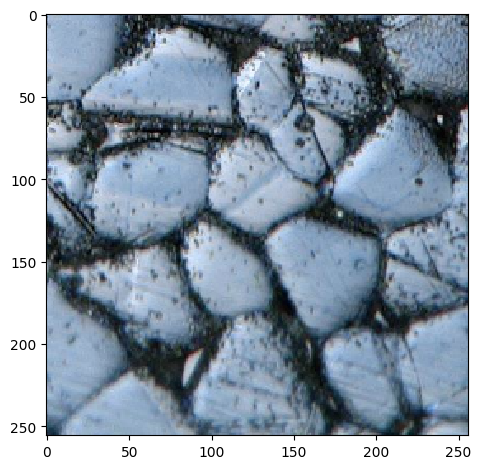

34
480


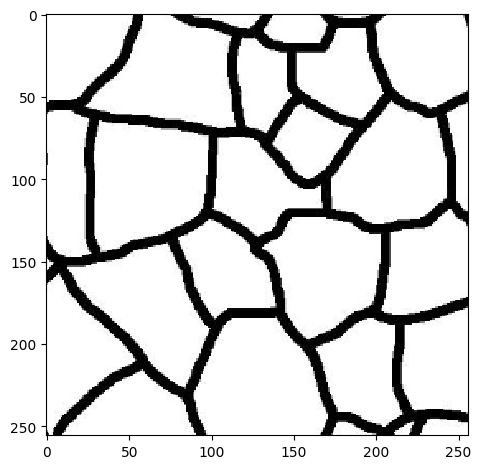

34
480


In [ ]:
ix = random.randint(0, 100)
print(ix)
imshow(images_test[ix])
plt.show()
print(ix)
print(len(images_test))

imshow(seg_test[ix])
plt.show()
print(ix)
print(len(seg_test))

In [ ]:
# create the X and Y (input and output)

IMG_T = np.array(images_test)
MASK_T = np.array(seg_test)

# change the Y to a boolean
MASK_T = np.where(MASK_T > 245, True, False)

mask_length = len(seg_test)
#basically reduce the 3 channel dimension RGB to just one boolean value

MASK_T = np.any(MASK_T, axis=-1)
MASK_T = MASK_T.reshape(mask_length, IMG_WIDTH, IMG_HEIGHT, 1)

In [ ]:
preds_T = model.predict(IMG_T, verbose=1)

preds_IMG_T = (preds_T < 0.5).astype(np.uint8)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [ ]:
##### DICE SCORE

# Initialize a list to store the dice coefficients for each mask
dice_coefficients = []

loop = len(MASK_T)

real_mask = MASK_T
pred_mask = preds_IMG_T


# Iterate through the masks in both directories
for i in range(loop):
  # Calculate the intersection of the masks
  intersection = np.sum(pred_mask[i] * real_mask[i])

  # Calculate the size of each mask
  predicted_mask_size = np.sum(pred_mask[i])
  real_mask_size = np.sum(real_mask[i])

  # Calculate the dice coefficient for the two masks
  dice = 2 * intersection / (predicted_mask_size + real_mask_size)

  # Add the dice coefficient to the list
  dice_coefficients.append(dice)

# Calculate the average dice coefficient for the set of masks
average_dice_coefficient = np.mean(dice_coefficients)

print(f'Average dice coefficient for all the real grain images only: {average_dice_coefficient:.4f}')

Average dice coefficient for all the real grain images only: 0.9180


21


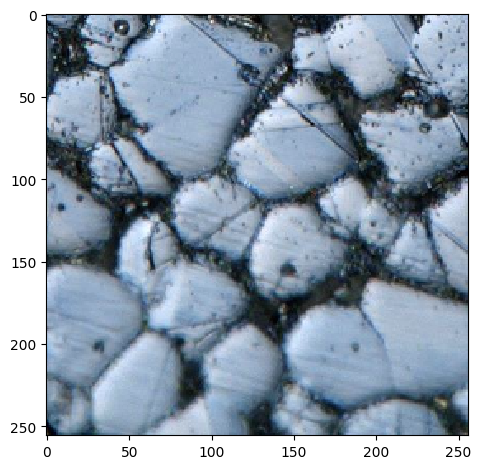

21
480


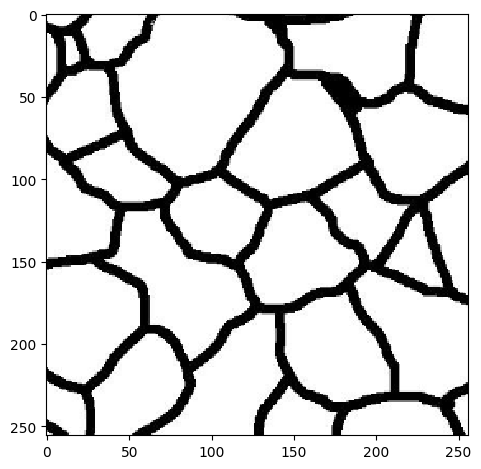

21
480


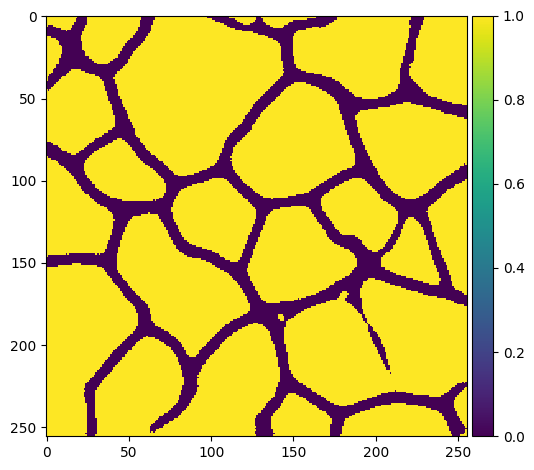

21
480


In [ ]:
ix = random.randint(0, 100)
print(ix)
imshow(images_test[ix])
plt.show()
print(ix)
print(len(images_test))

imshow(seg_test[ix])
plt.show()
print(ix)
print(len(seg_test))

imshow(preds_IMG_T[ix])
plt.show()
print(ix)
print(len(seg_test))

In [ ]:
preds_IMG_T[5].shape

(256, 256, 1)

In [ ]:
#save model

model.save('50MS_50AG_UNET.h5')

In [ ]:
#test loading the model

from tensorflow.keras.models import load_model

model = load_model('/content/50MS_50AG_UNET.h5')

In [ ]:
preds_T = model.predict(IMG_T, verbose=1)

preds_IMG_T = (preds_T > 0.5).astype(np.uint8)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
